In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.data import Data, InMemoryDataset

from sklearn.metrics import accuracy_score
import numpy as np

In [2]:
dataset = KarateClub()
data = dataset[0]

In [65]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [49]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)
        self.conv3 = GCNConv(2, data.y.unique().numel())

    def forward(self, data):
        X, edge_index = data.x, data.edge_index
        X = torch.tanh(self.conv1(X, edge_index))
        X = torch.tanh(self.conv2(X, edge_index))
        X = self.conv3(X, edge_index)
        return X
    
    def get_embeddings(self, data):
        X, edge_index = data.x, data.edge_index
        with torch.no_grad():
            X = torch.tanh(self.conv1(X, edge_index))
            X = self.conv2(X, edge_index)
        return X


In [142]:
class CustomKarateClub(InMemoryDataset):
    def __init__(self, transform=None):
        super().__init__('.', transform, None, None)

        G = nx.karate_club_graph()
        communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
        colors = np.zeros(G.number_of_nodes())
        for i, com in enumerate(communities):
            colors[list(com)] = i

        n_classes = np.unique(colors).shape[0]

        X = torch.eye(G.number_of_nodes()).float()
        y = torch.from_numpy(colors).long()

        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)
        train_mask = torch.zeros_like(y).to(dtype=torch.bool)
        for comm in communities:
            train_mask[next(iter(comm))] = True

        data = Data(x=X, y=y, edge_index=edge_index, train_mask=train_mask)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [143]:
dataset = CustomKarateClub()
data = dataset[0]

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

no_improvement = 0
best_loss = 1e6
eps = 1e-4

for epoch in range(15_000):
    predictions = model(data)
    loss = criterion(predictions[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        predictions = model(data)
        train_loss = loss.item()
        val_loss = criterion(predictions[~data.train_mask], data.y[~data.train_mask]).item()
        val_acc = accuracy_score(data.y[~data.train_mask], predictions[~data.train_mask].argmax(dim=1)).item()
        if not epoch % 100:
            print(f'{epoch=} {train_loss=:.4} {val_loss=:.4} {val_acc=:.4} ')

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= 150:
        print('Early stopping!')
        break


epoch=0 train_loss=1.117 val_loss=1.093 val_acc=0.4194 
epoch=100 train_loss=1.082 val_loss=1.089 val_acc=0.2581 
epoch=200 train_loss=1.049 val_loss=1.063 val_acc=0.5806 
epoch=300 train_loss=1.015 val_loss=1.038 val_acc=0.7097 
epoch=400 train_loss=0.9771 val_loss=1.011 val_acc=0.7742 
epoch=500 train_loss=0.9322 val_loss=0.978 val_acc=0.8387 
epoch=600 train_loss=0.8793 val_loss=0.9392 val_acc=0.9032 
epoch=700 train_loss=0.8187 val_loss=0.894 val_acc=0.9032 
epoch=800 train_loss=0.7534 val_loss=0.844 val_acc=0.9032 
epoch=900 train_loss=0.6884 val_loss=0.7925 val_acc=0.9032 
epoch=1000 train_loss=0.6288 val_loss=0.7434 val_acc=0.9355 
epoch=1100 train_loss=0.5777 val_loss=0.6991 val_acc=0.9355 
epoch=1200 train_loss=0.5354 val_loss=0.6609 val_acc=0.9355 
epoch=1300 train_loss=0.5009 val_loss=0.6285 val_acc=0.9032 
epoch=1400 train_loss=0.4727 val_loss=0.6012 val_acc=0.9032 
epoch=1500 train_loss=0.4493 val_loss=0.578 val_acc=0.9032 
epoch=1600 train_loss=0.4293 val_loss=0.5581 val_

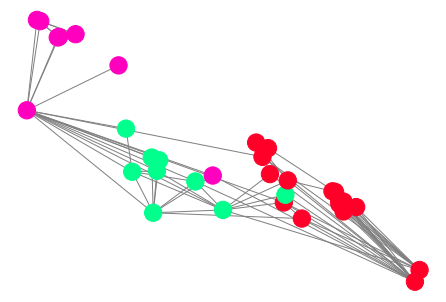

In [144]:
import networkx as nx
embeddings = model.get_embeddings(data)
pos = {i: embeddings[i, :].tolist() for i in range(embeddings.shape[0])}
nx.draw(G, pos=pos, 
        with_labels=False, node_color=colors, 
        cmap='gist_rainbow', edge_color='gray')